## Training the Driver Identification and Transport Mode Classification MTL model at Different Random Seeds.

In [1]:
import numpy as np
import pandas as pd
from sklearn.utils.class_weight import compute_class_weight

import torch
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary
from torch.utils.data import random_split, DataLoader

from src.engine import MTL_engine
from src.model_multitask import MultitaskModel
from src.plot import MTL_plot
from src.dataset import CombinedDataset

**Getting the seeds**

In [2]:
np.random.seed(0)

np.random.randint(low=0, high=200, size=4)

array([172,  47, 117, 192])

#### Computing class weights for both tasks

***driver identification***

In [3]:
y_train = pd.read_csv('./data/feature_maps_labels/train/metadata.csv')
y_train = y_train.iloc[:,1].values
print('Classes:', np.unique(y_train))

class_weights_dr = torch.tensor(compute_class_weight('balanced', classes=np.unique(y_train), y=y_train), dtype=torch.float32)
class_weights_dr = class_weights_dr / class_weights_dr.sum()
class_weights_dr = class_weights_dr.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

print('Class weights:', class_weights_dr)
del y_train

Classes: [0 1 2 3]
Class weights: tensor([0.0153, 0.2646, 0.1717, 0.5485], device='cuda:0')


Driver Id Class labels = [`'Not_driving'`, `'User1'`, `'User2'`, `'User3'`]

***transport mode classification***

In [4]:
y_train = pd.read_csv('./data/lstm_features_labels/train/metadata.csv')
y_train = y_train.iloc[:,1].values
print('Classes:', np.unique(y_train))

class_weights_tr = torch.tensor(compute_class_weight('balanced', classes=np.unique(y_train), y=y_train), dtype=torch.float32)
class_weights_tr = class_weights_tr / class_weights_tr.sum()
class_weights_tr = class_weights_tr.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

print('Class weights:', class_weights_tr)
del y_train

Classes: [0. 1. 2. 3. 4. 5. 6. 7.]
Class weights: tensor([0.0521, 0.0592, 0.4732, 0.1143, 0.0655, 0.1070, 0.0639, 0.0648],
       device='cuda:0')


### Random Seed: `172`

In [5]:
lstm_base_dir = './data/lstm_features_labels/'
fmap_base_dir = './data/feature_maps_labels/'
np.random.seed(172)

train_datasets = CombinedDataset(fmap_base_dir, lstm_base_dir, mode='train', 
                                 rescale=False, augment=True)
val_test_datasets = CombinedDataset(fmap_base_dir, lstm_base_dir, mode='valid',
                                 rescale=False, augment=True)

valid_datasets, test_datasets = random_split(val_test_datasets, [0.5, 0.5])

batch_size = 128
train_dl = DataLoader(train_datasets, batch_size, shuffle=True, num_workers=4)
valid_dl = DataLoader(valid_datasets, batch_size, shuffle=True, num_workers=4)
test_dl = DataLoader(test_datasets, batch_size, shuffle=False, num_workers=2)

In [6]:
len(train_datasets), len(valid_datasets), len(test_datasets)

(46240, 5782, 5781)

In [7]:
np.random.seed(172)

criterion_driver = nn.CrossEntropyLoss(weight=class_weights_dr)
criterion_transport = nn.CrossEntropyLoss(weight=class_weights_tr)
model = MultitaskModel(input_size=6, hidden_size=1024, num_layers=1, dropout=0.6409051706390204)
optimizer = optim.AdamW(model.parameters(), lr=0.0005392288692948486, weight_decay=0.0422480267454383)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.13618183112843046, patience=10)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = model.to(device)

In [8]:
engine = MTL_engine(model, optimizer, scheduler, criterion_driver, criterion_transport, device)

validation loss < training loss because of dropout. [*StackExchange*](https://stats.stackexchange.com/questions/187335/validation-error-less-than-training-error)

Train time: 325mins 10.2s

In [9]:
np.random.seed(172)

seed_172_hist = engine.train_validation(train_dl, valid_dl, epochs=50, alpha=1, beta=1,
                                        save_path='./model_checkpoint/seed_172_MTL_model_chkpt.pth')

np.save('./model_checkpoint/seed_172_MTL_model_history.npy', np.array(seed_172_hist))

Epoch [1/50], Train Loss: 2.7929, Train Transport Acc: 26.14%, Train Driver Acc: 51.01%, Val Loss: 2.3207, Val Transport Acc: 33.86%, Val Driver Acc: 69.02%
Epoch [2/50], Train Loss: 2.3072, Train Transport Acc: 37.27%, Train Driver Acc: 66.60%, Val Loss: 2.4187, Val Transport Acc: 33.85%, Val Driver Acc: 68.51%
Epoch [3/50], Train Loss: 1.8650, Train Transport Acc: 50.05%, Train Driver Acc: 70.01%, Val Loss: 1.5898, Val Transport Acc: 58.99%, Val Driver Acc: 73.37%
Epoch [4/50], Train Loss: 1.6273, Train Transport Acc: 57.50%, Train Driver Acc: 71.89%, Val Loss: 1.3755, Val Transport Acc: 64.46%, Val Driver Acc: 62.26%
Epoch [5/50], Train Loss: 1.4551, Train Transport Acc: 61.79%, Train Driver Acc: 72.93%, Val Loss: 1.2728, Val Transport Acc: 66.43%, Val Driver Acc: 78.33%
Epoch [6/50], Train Loss: 1.3523, Train Transport Acc: 63.90%, Train Driver Acc: 74.25%, Val Loss: 1.1635, Val Transport Acc: 69.13%, Val Driver Acc: 73.49%
Epoch [7/50], Train Loss: 1.2542, Train Transport Acc: 65.

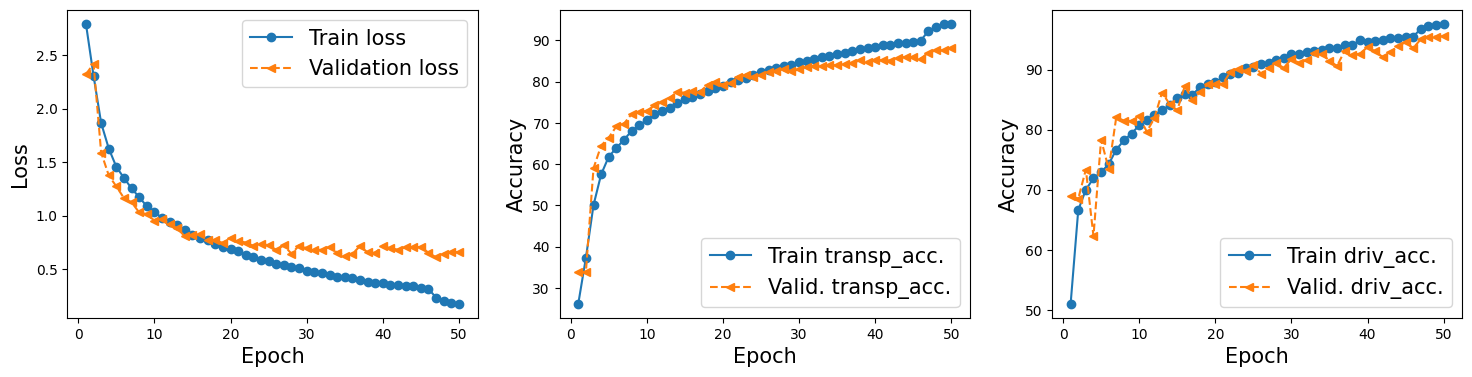

In [10]:
MTL_plot().plot_history(seed_172_hist)

In [11]:
engine.test(test_dl, criterion_transport, criterion_driver, alpha=1, beta=1)

   Test Loss: 0.6704, Test Transport Accuracy: 88.50%, Test Driver Accuracy: 96.14%


(0.6704352140710081, 88.49679986161564, 96.14253589344403)

### Random Seed: `47`

In [12]:
lstm_base_dir = './data/lstm_features_labels/'
fmap_base_dir = './data/feature_maps_labels/'
np.random.seed(47)

train_datasets = CombinedDataset(fmap_base_dir, lstm_base_dir, mode='train', 
                                 rescale=False, augment=True)
val_test_datasets = CombinedDataset(fmap_base_dir, lstm_base_dir, mode='valid',
                                 rescale=False, augment=True)

valid_datasets, test_datasets = random_split(val_test_datasets, [0.5, 0.5])

batch_size = 128
train_dl = DataLoader(train_datasets, batch_size, shuffle=True, num_workers=4)
valid_dl = DataLoader(valid_datasets, batch_size, shuffle=True, num_workers=4)
test_dl = DataLoader(test_datasets, batch_size, shuffle=False, num_workers=2)

In [13]:
len(train_datasets), len(valid_datasets), len(test_datasets)

(46240, 5782, 5781)

In [14]:
np.random.seed(47)

criterion_driver = nn.CrossEntropyLoss(weight=class_weights_dr)
criterion_transport = nn.CrossEntropyLoss(weight=class_weights_tr)
model = MultitaskModel(input_size=6, hidden_size=1024, num_layers=1, dropout=0.6409051706390204)
optimizer = optim.AdamW(model.parameters(), lr=0.0005392288692948486, weight_decay=0.0422480267454383)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.13618183112843046, patience=10)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = model.to(device)

In [15]:
engine = MTL_engine(model, optimizer, scheduler, criterion_driver, criterion_transport, device)

validation loss < training loss because of dropout. [*StackExchange*](https://stats.stackexchange.com/questions/187335/validation-error-less-than-training-error)

Train time: 314mins 14.7s

In [16]:
np.random.seed(47)

seed_47_hist = engine.train_validation(train_dl, valid_dl, epochs=50, alpha=1, beta=1,
                                        save_path='./model_checkpoint/seed_47_MTL_model_chkpt.pth')

np.save('./model_checkpoint/seed_47_MTL_model_history.npy', np.array(seed_47_hist))

Epoch [1/50], Train Loss: 2.8231, Train Transport Acc: 25.65%, Train Driver Acc: 48.08%, Val Loss: 2.3728, Val Transport Acc: 36.09%, Val Driver Acc: 78.07%
Epoch [2/50], Train Loss: 2.2936, Train Transport Acc: 37.10%, Train Driver Acc: 67.90%, Val Loss: 2.0167, Val Transport Acc: 42.72%, Val Driver Acc: 74.52%
Epoch [3/50], Train Loss: 1.9906, Train Transport Acc: 45.67%, Train Driver Acc: 69.07%, Val Loss: 1.7193, Val Transport Acc: 55.86%, Val Driver Acc: 70.79%
Epoch [4/50], Train Loss: 1.7098, Train Transport Acc: 53.73%, Train Driver Acc: 71.39%, Val Loss: 1.4412, Val Transport Acc: 59.91%, Val Driver Acc: 72.83%
Epoch [5/50], Train Loss: 1.5094, Train Transport Acc: 59.51%, Train Driver Acc: 73.40%, Val Loss: 1.2331, Val Transport Acc: 66.67%, Val Driver Acc: 78.47%
Epoch [6/50], Train Loss: 1.3703, Train Transport Acc: 62.70%, Train Driver Acc: 74.49%, Val Loss: 1.1657, Val Transport Acc: 69.02%, Val Driver Acc: 75.06%
Epoch [7/50], Train Loss: 1.2708, Train Transport Acc: 65.

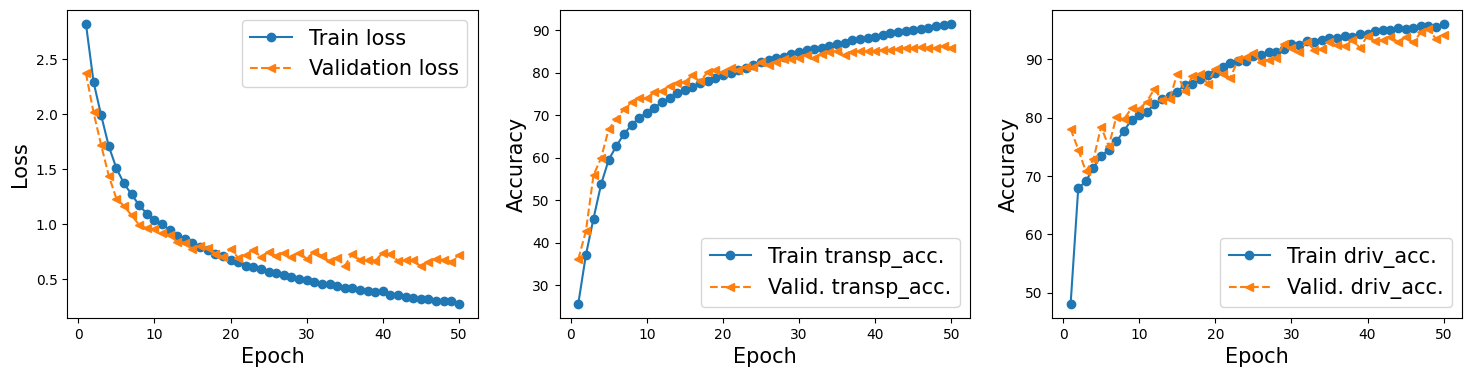

In [17]:
MTL_plot().plot_history(seed_47_hist)

In [18]:
engine.test(test_dl, criterion_transport, criterion_driver, alpha=1, beta=1)

   Test Loss: 0.6482, Test Transport Accuracy: 86.44%, Test Driver Accuracy: 94.83%


(0.6482466689270475, 86.43833246843107, 94.82788444905725)

### Random Seed: `117`

In [19]:
lstm_base_dir = './data/lstm_features_labels/'
fmap_base_dir = './data/feature_maps_labels/'
np.random.seed(117)

train_datasets = CombinedDataset(fmap_base_dir, lstm_base_dir, mode='train', 
                                 rescale=False, augment=True)
val_test_datasets = CombinedDataset(fmap_base_dir, lstm_base_dir, mode='valid',
                                 rescale=False, augment=True)

valid_datasets, test_datasets = random_split(val_test_datasets, [0.5, 0.5])

batch_size = 128
train_dl = DataLoader(train_datasets, batch_size, shuffle=True, num_workers=4)
valid_dl = DataLoader(valid_datasets, batch_size, shuffle=True, num_workers=4)
test_dl = DataLoader(test_datasets, batch_size, shuffle=False, num_workers=2)

In [20]:
len(train_datasets), len(valid_datasets), len(test_datasets)

(46240, 5782, 5781)

In [21]:
np.random.seed(117)

criterion_driver = nn.CrossEntropyLoss(weight=class_weights_dr)
criterion_transport = nn.CrossEntropyLoss(weight=class_weights_tr)
model = MultitaskModel(input_size=6, hidden_size=1024, num_layers=1, dropout=0.6409051706390204)
optimizer = optim.AdamW(model.parameters(), lr=0.0005392288692948486, weight_decay=0.0422480267454383)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.13618183112843046, patience=10)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = model.to(device)

In [22]:
engine = MTL_engine(model, optimizer, scheduler, criterion_driver, criterion_transport, device)

validation loss < training loss because of dropout. [*StackExchange*](https://stats.stackexchange.com/questions/187335/validation-error-less-than-training-error)

Train time: 327mins 29.1s

In [23]:
np.random.seed(117)

seed_117_hist = engine.train_validation(train_dl, valid_dl, epochs=50, alpha=1, beta=1,
                                        save_path='./model_checkpoint/seed_117_MTL_model_chkpt.pth')

np.save('./model_checkpoint/seed_117_MTL_model_history.npy', np.array(seed_117_hist))

Epoch [1/50], Train Loss: 2.8299, Train Transport Acc: 25.54%, Train Driver Acc: 56.18%, Val Loss: 2.3920, Val Transport Acc: 33.69%, Val Driver Acc: 63.77%
Epoch [2/50], Train Loss: 2.3671, Train Transport Acc: 35.71%, Train Driver Acc: 68.51%, Val Loss: 2.0544, Val Transport Acc: 44.45%, Val Driver Acc: 76.91%
Epoch [3/50], Train Loss: 2.0066, Train Transport Acc: 45.40%, Train Driver Acc: 70.57%, Val Loss: 1.6828, Val Transport Acc: 54.95%, Val Driver Acc: 74.42%
Epoch [4/50], Train Loss: 1.7425, Train Transport Acc: 53.87%, Train Driver Acc: 71.78%, Val Loss: 1.5948, Val Transport Acc: 58.73%, Val Driver Acc: 72.73%
Epoch [5/50], Train Loss: 1.6023, Train Transport Acc: 57.65%, Train Driver Acc: 71.98%, Val Loss: 1.3206, Val Transport Acc: 66.00%, Val Driver Acc: 75.75%
Epoch [6/50], Train Loss: 1.4298, Train Transport Acc: 62.62%, Train Driver Acc: 73.93%, Val Loss: 1.1727, Val Transport Acc: 68.32%, Val Driver Acc: 74.97%
Epoch [7/50], Train Loss: 1.3428, Train Transport Acc: 64.

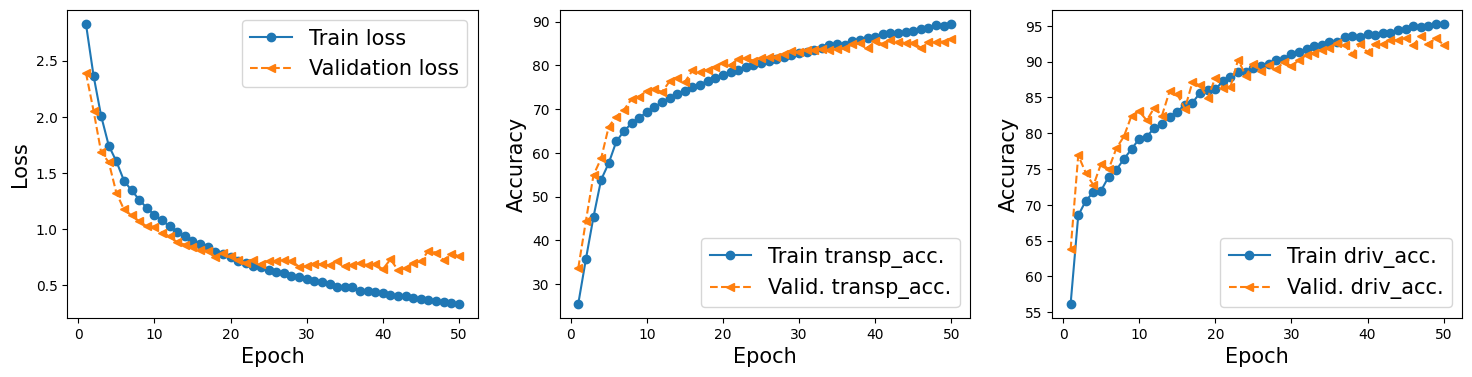

In [24]:
MTL_plot().plot_history(seed_117_hist)

In [25]:
engine.test(test_dl, criterion_transport, criterion_driver, alpha=1, beta=1)

   Test Loss: 0.7794, Test Transport Accuracy: 85.54%, Test Driver Accuracy: 92.87%


(0.7793536860009899, 85.53883411174537, 92.87320532779796)

### Random Seed: `192`

In [26]:
lstm_base_dir = './data/lstm_features_labels/'
fmap_base_dir = './data/feature_maps_labels/'
np.random.seed(192)

train_datasets = CombinedDataset(fmap_base_dir, lstm_base_dir, mode='train', 
                                 rescale=False, augment=True)
val_test_datasets = CombinedDataset(fmap_base_dir, lstm_base_dir, mode='valid',
                                 rescale=False, augment=True)

valid_datasets, test_datasets = random_split(val_test_datasets, [0.5, 0.5])

batch_size = 128
train_dl = DataLoader(train_datasets, batch_size, shuffle=True, num_workers=4)
valid_dl = DataLoader(valid_datasets, batch_size, shuffle=True, num_workers=4)
test_dl = DataLoader(test_datasets, batch_size, shuffle=False, num_workers=2)

In [27]:
len(train_datasets), len(valid_datasets), len(test_datasets)

(46240, 5782, 5781)

In [28]:
np.random.seed(192)

criterion_driver = nn.CrossEntropyLoss(weight=class_weights_dr)
criterion_transport = nn.CrossEntropyLoss(weight=class_weights_tr)
model = MultitaskModel(input_size=6, hidden_size=1024, num_layers=1, dropout=0.6409051706390204)
optimizer = optim.AdamW(model.parameters(), lr=0.0005392288692948486, weight_decay=0.0422480267454383)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.13618183112843046, patience=10)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = model.to(device)

In [29]:
engine = MTL_engine(model, optimizer, scheduler, criterion_driver, criterion_transport, device)

validation loss < training loss because of dropout. [*StackExchange*](https://stats.stackexchange.com/questions/187335/validation-error-less-than-training-error)

Train time: 323mins 15.7s

In [30]:
np.random.seed(192)

seed_192_hist = engine.train_validation(train_dl, valid_dl, epochs=50, alpha=1, beta=1,
                                        save_path='./model_checkpoint/seed_192_MTL_model_chkpt.pth')

np.save('./model_checkpoint/seed_192_MTL_model_history.npy', np.array(seed_192_hist))

Epoch [1/50], Train Loss: 2.7771, Train Transport Acc: 26.21%, Train Driver Acc: 55.24%, Val Loss: 2.2398, Val Transport Acc: 34.43%, Val Driver Acc: 64.86%
Epoch [2/50], Train Loss: 2.2083, Train Transport Acc: 38.38%, Train Driver Acc: 68.69%, Val Loss: 1.8012, Val Transport Acc: 49.08%, Val Driver Acc: 72.07%
Epoch [3/50], Train Loss: 1.8080, Train Transport Acc: 51.04%, Train Driver Acc: 71.18%, Val Loss: 1.5638, Val Transport Acc: 57.40%, Val Driver Acc: 77.64%
Epoch [4/50], Train Loss: 1.5797, Train Transport Acc: 57.01%, Train Driver Acc: 72.40%, Val Loss: 1.4490, Val Transport Acc: 64.42%, Val Driver Acc: 76.43%
Epoch [5/50], Train Loss: 1.4267, Train Transport Acc: 61.59%, Train Driver Acc: 73.17%, Val Loss: 1.2141, Val Transport Acc: 66.50%, Val Driver Acc: 78.42%
Epoch [6/50], Train Loss: 1.3174, Train Transport Acc: 64.04%, Train Driver Acc: 75.43%, Val Loss: 1.1874, Val Transport Acc: 69.80%, Val Driver Acc: 77.17%
Epoch [7/50], Train Loss: 1.1967, Train Transport Acc: 66.

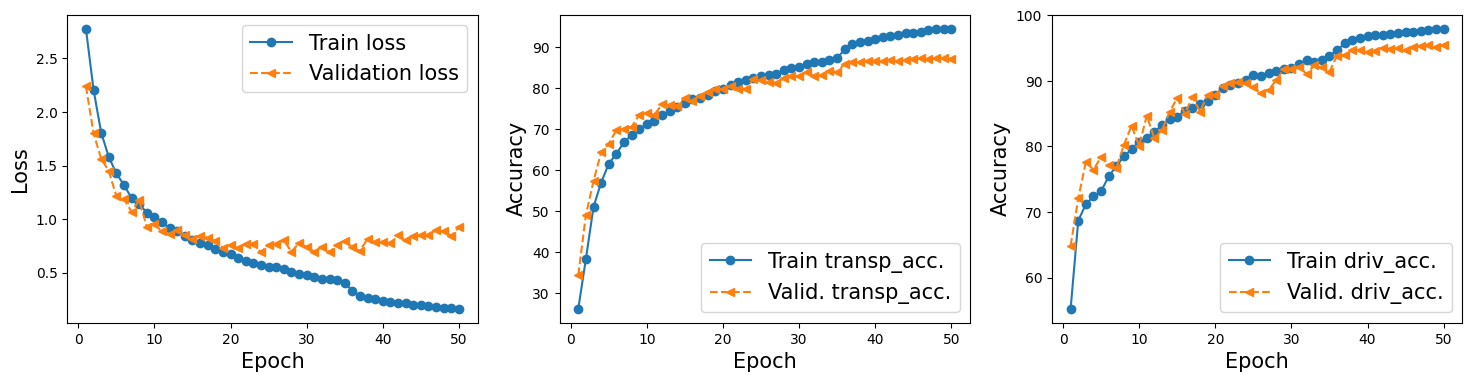

In [31]:
MTL_plot().plot_history(seed_192_hist)

In [32]:
engine.test(test_dl, criterion_transport, criterion_driver, alpha=1, beta=1)

   Test Loss: 0.7195, Test Transport Accuracy: 88.36%, Test Driver Accuracy: 95.21%


(0.7195327320824498, 88.3584154990486, 95.20844144611658)